# Exercise: Taxonomy Induction

<br>
In this exercise, we will perform the various steps commonly employed for unsupervised taxonomy induction from text corpora. Taxonomy induction from text typically consists of three main steps:

<ol>
  <li><b>Relations Extraction:</b> In this step, we use lexico-syntactic patterns to extract <b>IsA</b> relations from text. An example of IsA relation is (<i>apple, fruit</i>), which implies that <i>apple</i> is a type of fruit.</li>
  <br>
  <li><b>Initial Graph Construction:</b> In this step, we aggregate the extracted IsA relations to construct a potentially-noisy initial hypernym graph.</li>
  <br>
  <li><b>Graph Pruning:</b> In the final step, we perform some pruning or optimization steps to induce the a final clean taxonomy.</li>
</ol>  

<br>
We will describe these steps in detail in the rest of this exercise. 


## Question 1 - Relations Extraction


In this part of the exercise, we will run a small-scale extraction of IsA relations and inspect the results. Relations extraction uses lexico-syntactic patterns to identify IsA relations from unstructured text. Examples of lexico-syntactic patterns include:

 Lexico-syntactic pattern | Sample matching text
  ------|------------------
  <b>X</b> is a <b>Y</b>     | <i><b>apple</b> is a <b>fruit</b></i>, <i><b>switzerland</b> is a <b>country</b></i>
  <b>X</b> such as <b>Y</b>     | <i><b>fruits</b> such as <b>mango</b></i>, <i><b>scientists</b> such as <b>Einstein</b></i>
  <b>X</b> is an example of <b>Y</b>     | <i><b>iphone</b> is an example of <b>smartphone</b></i>
  
  <br>
  In this exercise, we will use such lexico-syntactic patterns to identify IsA relations from text.
  
  
  ###  Question 1.a

  Load the given file <b>wiki_food_en.txt</b> into memory using the following code:
  
  
  

In [1]:
def load_text_file(filename):
    file_text = []
    with open(filename) as fp:
        for line in fp:
            file_text.append(line.strip().lower())
    return " ".join(file_text)

file_text = load_text_file("wiki_food_en.txt")

<br>
The following code uses the regular expression library to detect lexico-syntactic patterns in the file_text. The example below uses the regular expression "X is a Y". Fill in the blanks (...):


In [6]:
import re


def find_matches(file_text, regexp_string):
    #Compile a regular expression 
    regexp = re.compile(regexp_string)
    
    #Find all matches with the given regular expression
    matches = re.findall(regexp, file_text)
    
    return matches

isa_matches  = find_matches(file_text, "[a-z]+ is a ...")
suchAs_patt1 = find_matches(file_text, "[a-z]+ such as ...")
suchAs_patt2 = find_matches(file_text, "such [a-z]+ as ...")
other_patt   = find_matches(file_text,"[a-z]+ and other ...") 

In [8]:
print(suchAs_patt1[:20])

['pig such as the', 'beverages such as coc', 'beverages such as  ic', 'emulsifiers such as egg', 'flavorings such as  sa', 'varieties such as all', 'fruit such as  ap', 'pests such as the', 'ceremonies such as wed', 'molds such as  as', 'pests such as nav', 'versions such as the', 'pests such as the', 'ceremonies such as wed', 'molds such as  as', 'pests such as nav', 'versions such as the', 'curries such as  hu', 'illnesses such as inf', 'regions such as  ca']


In [9]:
print(suchAs_patt2[:20])

['such toppings as  fr', 'such serves as an ', 'such toppings as . p', 'such flavors as cho', 'such factors as ter', 'such celebrities as  ba', 'such countries as ger', 'such dishes as  go', 'such pastries as  ba', 'such foods as piz', 'such words as the', 'such dishes as  ca', 'such factors as ter', 'such companies as ari', 'such ingredients as wat', 'such ingredients as wat', 'such companies as  as', 'such fare as  be', 'such toppings as  fr', 'such places as tha']


In [10]:
print(other_patt[:20])

['france and other cou', 'figs and other rec', 'azerbaijan and other cen', 'olives and other tre', 'azerbaijan and other cen', 'olives and other tre', 'rye and other flo', 'france and other eur', 'sauces and other sau', 'mixes and other glu', 'petals and other flo', 'petals and other flo', 'tariff and other sup', 'wars and other fai', 'wine and other ing', 'date and other agr', 'soups and other foo', 'patties and other bul', 'spices and other sub', 'sugars and other com']


<br>
 ###  Question 1.b

Run the above code for relations extraction with the following lexico-syntactic patterns:

<ol>
  <li>X such as Y</li>
  <li>such X as Y</li>
<li>X and other Y</li>  
</ol>

Manually inspect the results and compute the accuracies of first 20 matches for each lexico-syntactic pattern. What do you observe? Is there any important difference between patterns no. 1,2 and 3? 

## Question 2 - Graph Construction

As you noticed in the previous step, the output of lexico-syntactic patterns-based relations extraction contains significant noise. The task of noise removal is fairly involved and beyond the scope of this exercise. For further reading, we recommend this paper, which demonstrates a state-of-the-art effort for IsA relations extraction (<a href="http://webdatacommons.org/isadb/lrec2016.pdf">A Large Database of Hypernymy Relations Extracted from the Web</a>).

In this part of the exercise, we assume that IsA relations extracted using a state-of-the-art approach are already available. Given these relations, the aim of this step is to construct an initial potentially-noisy hypernym graph.

###  Question 2.a


Load the IsA relations of the food domain from the given file "food_isa_relations.txt" using the following code:

In [11]:
rels = []
with open("food_isa_relations.txt") as fp:
    for line in fp.readlines():
        toks = line.strip().split('\t')
        rels.append((toks[0],toks[1],float(toks[2])))

In python, graphs are better handled as a default 2-level dictionary. For example, the edge (<i>apple</i>,<i>fruit</i>, freq) is represented as a two-level map:

map['apple']['fruit'] = freq

The following code converts the IsA relations loaded from the file into a 2-level dictionary. Fill in the blanks:

In [14]:
from collections import defaultdict

noisy_relations = defaultdict(dict)
for hypo, hyper, freq in rels:
    noisy_relations[hypo][hyper] = freq

<br>

###  Question 2.b

The next step of taxonomy induction involves removing and filtering out noisy IsA relations. In a real scenario, this usually involves a wide variety of steps. However, in this exercise, we will implement only one step. In this step, we will sort all the hypernyms for each hyponym, and only retain top-5 hypernyms for each hyponym.

First, print the hypernyms of 'apple':

In [15]:
noisy_relations['apple']

{'apple': 0.41334243636,
 'brand': 0.0915626602388,
 'company': 0.547120747653,
 'company in the world': 0.0747098410221,
 'crop': 0.0988772876235,
 'flavour': 0.0858994706649,
 'food': 0.147812587177,
 'fruit': 1.0,
 'fruit tree': 0.115782511138,
 'hardware company': 0.0897298351702,
 'ingredient': 0.068957229831,
 'manufacturer': 0.079702775123,
 'orange': 0.155466692675,
 'product': 0.0697003665663,
 'rival': 0.0788062030625,
 'tag': 0.0736281177128,
 'tech company': 0.120745147762,
 'technology company': 0.0755438963724,
 'tree': 0.110838111316,
 'vegetable': 0.132148274312}

<br>
Fill in the blanks in the following code: 

In [51]:
def sort_dict(noisy_relations):
    for hypo in noisy_relations.keys():
        sorted_hypernyms = sorted(noisy_relations[hypo].items(),key = lambda x : x[1])
        noisy_relations[hypo] = {k:v for (k,v) in sorted_hypernyms}
    return noisy_relations

In [53]:
noisy_relations = sort_dict(noisy_relations)
print(noisy_relations['apple'])

{'ingredient': 0.068957229831, 'product': 0.0697003665663, 'tag': 0.0736281177128, 'company in the world': 0.0747098410221, 'technology company': 0.0755438963724, 'rival': 0.0788062030625, 'manufacturer': 0.079702775123, 'flavour': 0.0858994706649, 'hardware company': 0.0897298351702, 'brand': 0.0915626602388, 'crop': 0.0988772876235, 'tree': 0.110838111316, 'fruit tree': 0.115782511138, 'tech company': 0.120745147762, 'vegetable': 0.132148274312, 'food': 0.147812587177, 'orange': 0.155466692675, 'apple': 0.41334243636, 'company': 0.547120747653, 'fruit': 1.0}


###  Question 2.c

In the next step, we would first convert the set of filtered IsA relations into a graph. First install the library networkx and matplotlib:

   $ pip install networkx<br>
   
   $ pip install matplotlib
   


Further, use the following code:

In [55]:
import networkx as nx
import matplotlib.pyplot as plt

G=nx.DiGraph()

for hypo in noisy_relations.keys():
    for hyper in noisy_relations[hypo].keys():
        G.add_edge(hypo, hyper)
                

In [63]:
for path in nx.all_simple_paths(G,'apple','food'):
    print(path)

['apple', 'ingredient', 'product', 'food']
['apple', 'ingredient', 'food']
['apple', 'product', 'food']
['apple', 'vegetable', 'dish', 'food']
['apple', 'vegetable', 'ingredient', 'product', 'food']
['apple', 'vegetable', 'ingredient', 'food']
['apple', 'vegetable', 'product', 'food']
['apple', 'vegetable', 'food']
['apple', 'food']
['apple', 'orange', 'product', 'food']
['apple', 'orange', 'food']
['apple', 'orange', 'vegetable', 'dish', 'food']
['apple', 'orange', 'vegetable', 'ingredient', 'product', 'food']
['apple', 'orange', 'vegetable', 'ingredient', 'food']
['apple', 'orange', 'vegetable', 'product', 'food']
['apple', 'orange', 'vegetable', 'food']
['apple', 'orange', 'fruit', 'snack', 'drink', 'beverage', 'food']
['apple', 'orange', 'fruit', 'snack', 'drink', 'beverage', 'product', 'food']
['apple', 'orange', 'fruit', 'snack', 'drink', 'food']
['apple', 'orange', 'fruit', 'snack', 'drink', 'product', 'food']
['apple', 'orange', 'fruit', 'snack', 'product', 'food']
['apple', 'o

In [64]:
for path in nx.all_simple_paths(G,'fusilli','food'):
    print(path)

['fusilli', 'pasta', 'paste', 'fruit', 'snack', 'drink', 'beverage', 'food']
['fusilli', 'pasta', 'paste', 'fruit', 'snack', 'drink', 'beverage', 'product', 'food']
['fusilli', 'pasta', 'paste', 'fruit', 'snack', 'drink', 'food']
['fusilli', 'pasta', 'paste', 'fruit', 'snack', 'drink', 'product', 'food']
['fusilli', 'pasta', 'paste', 'fruit', 'snack', 'product', 'food']
['fusilli', 'pasta', 'paste', 'fruit', 'snack', 'food']
['fusilli', 'pasta', 'paste', 'fruit', 'ingredient', 'product', 'food']
['fusilli', 'pasta', 'paste', 'fruit', 'ingredient', 'food']
['fusilli', 'pasta', 'paste', 'fruit', 'product', 'food']
['fusilli', 'pasta', 'paste', 'fruit', 'food']
['fusilli', 'pasta', 'paste', 'dish', 'food']
['fusilli', 'pasta', 'paste', 'product', 'food']
['fusilli', 'pasta', 'paste', 'spice', 'food']
['fusilli', 'pasta', 'paste', 'spice', 'product', 'food']
['fusilli', 'pasta', 'paste', 'spice', 'ingredient', 'product', 'food']
['fusilli', 'pasta', 'paste', 'spice', 'ingredient', 'food']


In [68]:
for path in nx.all_simple_paths(G,'okra','food'):
    print(path)

['okra', 'ingredient', 'product', 'food']
['okra', 'ingredient', 'food']
['okra', 'vegetable', 'dish', 'food']
['okra', 'vegetable', 'ingredient', 'product', 'food']
['okra', 'vegetable', 'ingredient', 'food']
['okra', 'vegetable', 'product', 'food']
['okra', 'vegetable', 'food']


<br>
Print all the paths between the following terms (Hint: use the networkx function all_simple_paths):

1. 'apple' and 'food'
2. 'fusilli' and 'food'
3.  'okra' and 'food' 

Do you notice any relationship between the length of the path and its accuracy?


###  Question 2.d

In this step, we will now build a taxonomy. We will undertake the following steps:

<ol>
  <li> Let the vocabulary be {'apple', 'mango', 'peach', 'orange', 'banana'}.</li> 
<li> Let the root of the taxonomy be 'food'.</li> 
<li> Find all simple paths between terms in the vocabulary and the root. </li>
<li> Retain all simple paths of length $l$.
<li> Construct a graph by aggregatiing all the edges in the retained paths. </li>

The below code implements the above steps. Fill in the blanks:


In [82]:
def select_paths(vocab, root, l):
    retained_paths = []
    for term in vocab:
        for path in nx.all_simple_paths(G,term,root):
            if len(path) == l:
                retained_paths.append(path)
    return retained_paths


def aggregate_paths(paths):
    agg_graph = defaultdict(dict)
    
    for path in paths:
        for i,term in enumerate(path[0:len(path) -1]):
            agg_graph[term][path[i+1]] = 1
            
    return agg_graph


V = ['apple', 'mango', 'peach', 'orange', 'banana']
root = 'food'

###  Question 2.e

Plot the aggregated graph using the previous steps but with different path lengths (For example, 2 or 4). What do you notice?

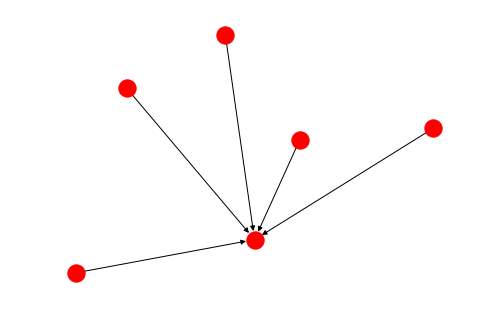

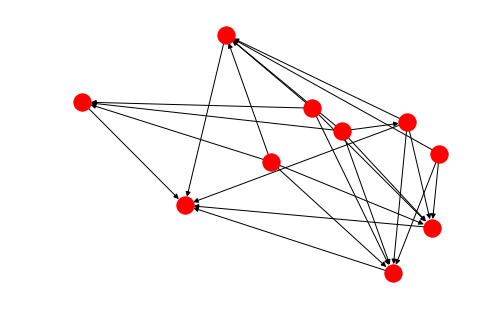

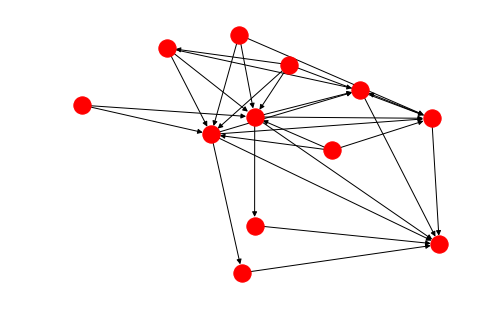

In [83]:
plots = [2,3,4]
for i in plots:
    
    graph = aggregate_paths(select_paths(V, root, i))
 
    # Plot the graph
    Gt = nx.DiGraph()
    for k in graph.keys():
        for k1 in graph[k].keys():
            Gt.add_edge(k,k1)

    nx.draw(Gt)        
    plt.show()


###  Question 2.f

Repeat steps from 2.b to 2.e but without filtering the noisy relations in step 2.b. What do you observe?